In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from typing import Any, Dict, List, Tuple

# ---------- Import own python files ----------
sys.path.append('../')

import helper.variables as vars

from database.movie import Movies
from database.user import Users
from database.genre import Genres
from helper.file_system_interaction import load_object_from_file, save_object_in_file

In [3]:
# Define constants
HISTORY_LEN = 10
MIN_MOVIE_HISTORY_LEN = 5
DISTANCE_TO_OTHER_MOVIES = 0.1
TRAIN_DATA_RELATIONSHIP = 0.85
SEED = 1234

# Constants for computing the difference between multiple values
EPSILON = 50
INDEPENDENT_MAX_DIFF_PER_GENRE = 5
NUMBER_OF_INTERVALS = 5
# nan_movies = []

In [4]:
# Set seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
def find_real_genres_to_all_user_movies(movies: Dict[int, Dict[str, Any]], users: Dict[int, Dict[str, Any]]) -> Dict[int, List[np.array]]:
    """
        Find real genres of users (= watched movies) with real genres of movies.
        Returns a dict of all movies as real genres = numpy arrays.
    """

    user_movie_histories = {}
    i = 0

    for user_id, reviews in users.items():
        reviews = dict(sorted(reviews.items()))  # Sort user reviews by creation date
        user_movie_histories[user_id] = []

        for _, review in reviews.items():
            if i % 1000 == 0:
                print(f"Iteration: {i}")
            movie_id = int(review["movie_id"])
            real_movie_genres = movies[movie_id]["real_genres"]
            user_movie_histories[user_id].append(np.array(real_movie_genres, dtype=np.float64))
            i += 1

    return user_movie_histories


def find_real_genres_to_all_user_movies_for_visualization(movies: Dict[int,
        Dict[str, Any]], users: Dict[int, Dict[str, Any]],
        genres: Dict[int, Dict[str, str]]) -> pd.DataFrame:
    """
        Find real genres of users (= watched movies) with real genres of movies.
        Returns a pandas DataFrame containing all movies with real genres
        watched by users. It's useful for visualizations and analyzations of
        read data.
    """

    # global nan_movies

    genre_names = [genre["name"] for genre in genres.values()]
    user_movie_histories = dict(zip(genre_names + ["username"], [[] for _ in range(len(genre_names) + 1)]))
    i = 0

    for user_id, reviews in users.items():
        reviews = dict(sorted(reviews.items()))  # Sort user reviews by creation date

        for _, review in reviews.items():
            if i % 1000 == 0:
                print(f"Iteration: {i}")
            movie_id = int(review["movie_id"])
            real_movie_genres = movies[movie_id]["real_genres"]

            for j, genre in enumerate(genre_names):
                user_movie_histories[genre].append(real_movie_genres[j])
            user_movie_histories["username"].append(user_id)
            i += 1

            # if np.isnan(np.min(real_movie_genres)):
            #     nan_movies.append(movie_id)

    return pd.DataFrame(user_movie_histories)


def extract_features(user_movie_histories: Dict[int, List[np.array]],
        movie_history_len: int, min_movie_history_len: int=MIN_MOVIE_HISTORY_LEN,
        fill_history_len_with_zero_movies=True) -> List[Tuple[np.array, np.array]]:
    """
        Extract features: partionate user histories into parts with length
        "min_movie_history_len" so that next movie is the predicted target.
        Returns tuples consisting of the last seen movies and the next one
        to predict (= target, label) out ot the previous ones.
    """

    all_extracted_features = []
    skipped_histories, used_histories = 0, 0

    for users_movie_history in user_movie_histories.values():  # Iterate over all users' histories
        if len(users_movie_history) < min_movie_history_len\
                or ((not fill_history_len_with_zero_movies)\
                    and len(users_movie_history) <= movie_history_len):  # User has not enough movies watched
            skipped_histories += 1
            continue
        elif fill_history_len_with_zero_movies\
                and len(users_movie_history) <= movie_history_len:  # Use has watched enoguh movies, but not many
            # Find movies and target/label
            movies = users_movie_history[:-1]
            target_label = users_movie_history[-1]

            # Fill missing movies with zeros
            number_of_missing_movies = movie_history_len - len(movies)
            zero_movie = np.zeros(target_label.shape[0])  # Create movie containing only 0 for all real genres
            zero_movies = list(np.tile(zero_movie, (number_of_missing_movies, 1)))

            # Create one list with zero movies and watched movies of a user
            history_feature = (zero_movies + movies, target_label)
            all_extracted_features.append(history_feature)
        else:  # Use history only, if it is long enough
            all_extracted_features.extend(
                [(np.copy(users_movie_history[i:i+movie_history_len]), users_movie_history[movie_history_len])
                    for i in range(0, len(users_movie_history) - movie_history_len - 1, movie_history_len)]
            )

    used_histories = len(user_movie_histories) - skipped_histories
    print(f"Extracted histories of {used_histories} users")
    print(f"Skipped {skipped_histories} histories, because they have less than "\
          + f"{min_movie_history_len} movies in their history of movies")

    return used_histories, all_extracted_features


def calc_distance(ys_true: np.float64, ys_pred: np.float64, allowed_diff_per_value: float=INDEPENDENT_MAX_DIFF_PER_GENRE,
                  number_of_intervals: float=NUMBER_OF_INTERVALS) -> np.float64:
    """
        Computes distance between the true and the predicted y values.
        For each combination of true an dpredicted y values:\n
        If the true y value is higher, then a higher difference is
        acceptable, else the difference must be lower, e.g.:\n
        y_true = 86; y_pred = 80\n
        -> difference should be a maximum of 8.5\n
        => y_pred is okay\n
        \n
        y_true = 4; y_pred = 10\n
        -> difference should be a maximum of 0.5\n
        => y_pred is not okay\n
        \n
        Differences increase by 0.5 in the following intervals:\n
        Intervals:  [0,5), [5,10), [10,15), [15,20), ...\n
        Differences: 0.5      1      1.5       2     ...\n
        \n
        Returns the sum of all differences being too high.
    """

    overall_diff = 0

    for y_true, y_pred in zip(ys_true, ys_pred):
        diff = abs(y_true - y_pred)
        allowed_diff = (y_pred // number_of_intervals + 1) * allowed_diff_per_value

        if allowed_diff < diff:  # Only add differenes, which are too high
            overall_diff += diff

    return overall_diff


def evaluate_model(y_test: np.array, predictions: np.array) -> float:
    """
        Evaluates a model by comparing true test values with predicted y
        values. Compare each y value will be compared with its corresponding
        prediction value.\n
        Returns the accuracy.
    """

    # Define variables
    distances = []

    # Compute distances of pair of predicted and true y values
    for y, y_pred in zip(y_test, predictions):
        # distance = np.linalg.norm(y - y_pred)  # Euclidean distances between points
        distance = calc_distance(y, y_pred)  # Own distane per genre/value
        distances.append(distance)

    # Output some metrics
    overall_mean_deviation = sum(distances) / len(distances)
    correct_classifications_distances = [dist for dist in distances if dist <= EPSILON]
    false_classifications_distances = [dist for dist in distances if EPSILON < dist]
    mean_deviation_from_correct_classifications = sum(correct_classifications_distances) / len(correct_classifications_distances)
    mean_deviation_from_false_classifications = sum(false_classifications_distances) / len(false_classifications_distances)
    print(f"\nCorrect classifications: {len(correct_classifications_distances)},"\
        + f"false classifications: {len(false_classifications_distances)}, "\
        + f"accuracy: {len(correct_classifications_distances) / len(distances)}")
    print(f"Correct classifications deviations: {mean_deviation_from_correct_classifications}")
    print(f"False classifications deviations: {mean_deviation_from_false_classifications}")
    print(f"Overall mean deviation: {overall_mean_deviation}")

    return len(correct_classifications_distances) / len(distances)

In [10]:
# Read data from database
all_movies = Movies().get_all()
all_users = Users().get_all()
all_genres = Genres().get_all()

In [11]:
# Find real genres to movies, users have watched
user_movie_histories = find_real_genres_to_all_user_movies(all_movies, all_users)
save_object_in_file(vars.user_history_file_path_with_real_genres, user_movie_histories)

Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Iteration: 11000
Iteration: 12000
Iteration: 13000
Iteration: 14000
Iteration: 15000
Iteration: 16000
Iteration: 17000
Iteration: 18000
Iteration: 19000
Iteration: 20000
Iteration: 21000
Iteration: 22000
Iteration: 23000
Iteration: 24000
Iteration: 25000
Iteration: 26000
Iteration: 27000
Iteration: 28000
Iteration: 29000
Iteration: 30000
Iteration: 31000


In [12]:
# Read data again and create a pandas DataFrame with the 
df_user_movie_histories = find_real_genres_to_all_user_movies_for_visualization(all_movies, all_users, all_genres)
save_object_in_file(vars.user_history_file_path_with_real_genres_visualization, df_user_movie_histories)
# print(nan_movies)

Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Iteration: 11000
Iteration: 12000
Iteration: 13000
Iteration: 14000
Iteration: 15000
Iteration: 16000
Iteration: 17000
Iteration: 18000
Iteration: 19000
Iteration: 20000
Iteration: 21000
Iteration: 22000
Iteration: 23000
Iteration: 24000
Iteration: 25000
Iteration: 26000
Iteration: 27000
Iteration: 28000
Iteration: 29000
Iteration: 30000
Iteration: 31000


NameError: name 'nan_movies' is not defined

In [ ]:
    # Visualize data
    # TODO: Look for mean genres
    # TODO: Compare genres
    # TODO: Cluster genres
    # TODO: View history of movies, the user have watched => progress change of genres
    # TODO: Eigene Loss-Funktion definieren

Variance/Amount of left/remaining information: [0.20759312 0.15768275]
Variance: [1983.12180073 1506.33176241]


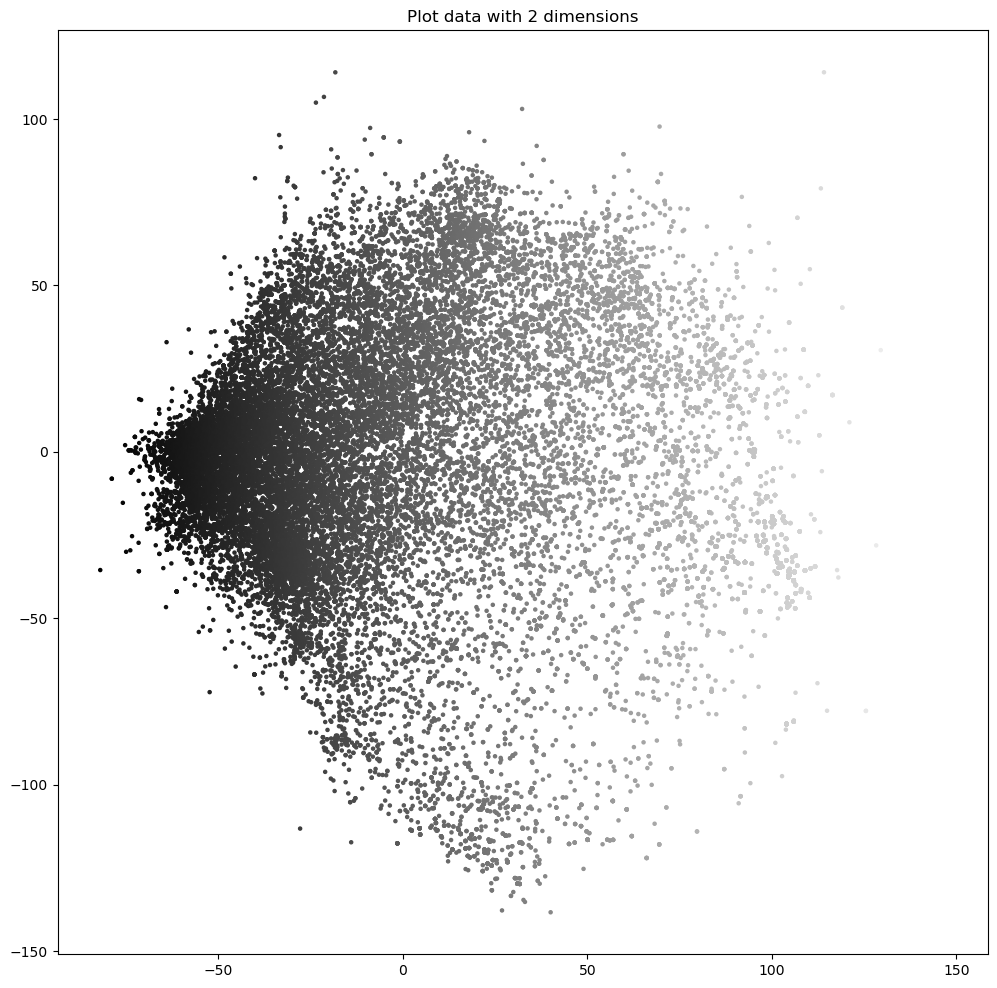

Variance/Amount of left/remaining information: [0.20759312 0.15768275 0.12378476]
Variance: [1983.12180073 1506.33176241 1182.50669601]


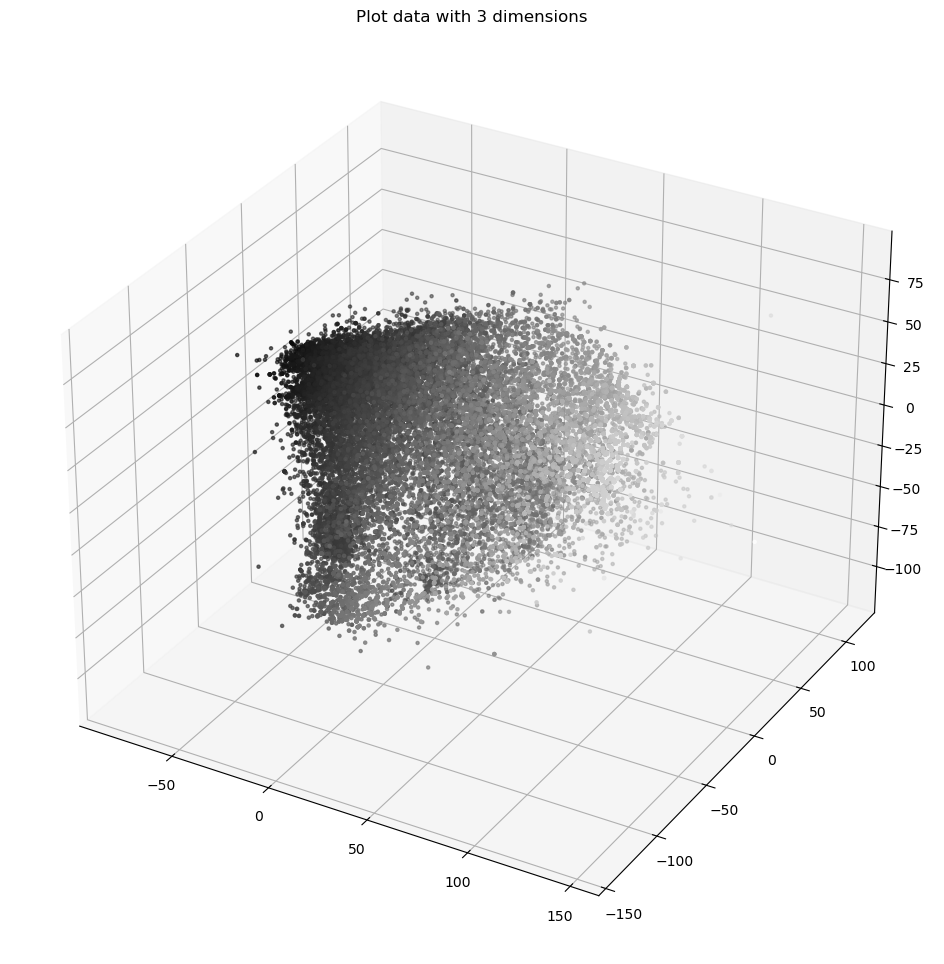

In [27]:
# Analyze principal components with PCA
def plotprincipalcomponents_with_PCA(components: int, df_original: pd.DataFrame, point_size: int=5) -> None:
    """
        Computes "components" many principal components for the passed
        DataFrame "df" and plots the results. For this the number of
        components must be 2 for 2D or 3 for 3D.
    """

    assert 2 <= components <= 3

    # Compute principal components
    pca = PCA(n_components=components)
    res = pca.fit_transform(df_original.values)
    print(f"Variance/Amount of left/remaining information: {pca.explained_variance_ratio_}")
    df = pd.DataFrame(data=res, columns=[f"c{i}" for i in range(len(res[0]))])
    print(f"Variance: {pca.explained_variance_}")

    # Plot results
    fig = plt.figure(figsize=(12, 12))
    values = [df[col].values for col in df.columns]

    if components == 3:
        ax = fig.add_subplot(projection='3d')
        values = [df[col].values for col in df.columns]
        ax.scatter(*values, c=values[0], s=point_size)
    else:
        plt.scatter(*values, c=values[0], s=point_size)

    plt.gray()
    plt.title(f"Plot data with {components} dimensions")
    plt.show()


# Read data from file
df_user_movie_histories = load_object_from_file(vars.user_history_file_path_with_real_genres_visualization)
df_user_movie_histories = df_user_movie_histories.loc[:, df_user_movie_histories.columns != "username"]  # Ignore column with usernames

# Do a 2D plot
plotprincipalcomponents_with_PCA(2, df_user_movie_histories)

# Do a 3D plot
plotprincipalcomponents_with_PCA(3, df_user_movie_histories)